In [9]:
from pylab import *
import h5py
import lal
import emcee
import scipy.linalg as sl
from collections import OrderedDict
import pandas as pd
from multiprocessing import Pool
from contextlib import closing
import os
from tqdm import tqdm
import sys
sys.path.append('..')
import reconstructwf as rwf
import likelihood as ll
from spins_and_masses import transform_spins, m1m2_from_mtotq
from scipy.signal import find_peaks

data_dir = '/home/simona.miller/time-domain-gw-inference/data/'

Copy over functions from `io` because not working

In [13]:
def load_raw_data(path=data_dir+'input/GW190521_data/{}-{}_GWOSC_16KHZ_R2-1242442952-32.hdf5',
                  ifos=('H1', 'L1', 'V1'), verbose=True):
    
    raw_time_dict = {}
    raw_data_dict = {}
    
    for ifo in ifos:
        # for real data downloaded from gwosc...
        with h5py.File(path.format(ifo[0], ifo), 'r') as f:
            strain = array(f['strain/Strain'])
            T0 = f['meta/GPSstart'][()]
            ts = T0 + arange(len(strain))*f['meta/Duration'][()]/len(strain)
        
        raw_time_dict[ifo] = ts
        raw_data_dict[ifo] = strain
    
        fsamp = 1.0/(ts[1]-ts[0])
        if verbose:
            print("Raw %s data sampled at %.1f Hz" % (ifo, fsamp))
            
    return raw_time_dict, raw_data_dict


def get_pe(raw_time_dict, path=data_dir+'input/GW190521_data/GW190521_posterior_samples.h5', 
           psd_path=None, verbose=True):
    
    # Interferometer names 
    ifos = list(raw_time_dict.keys())
    
    # Load in posterior samples
    with h5py.File(path, 'r') as f:
        pe_samples = f['NRSur7dq4']['posterior_samples'][()]
    
    # Load in PSDs
    pe_psds = {}
    if psd_path is None: # use same file as posteriors 
        with h5py.File(path, 'r') as f:
            for ifo in ifos:
                pe_psds[ifo] = f['NRSur7dq4']['psds'][ifo][()]
    else: # use different, provided file
        for ifo in ifos: 
            pe_psds[ifo] = genfromtxt(psd_path.format(ifo), dtype=float)
            
    # Find sample where posterior is maximized
    log_prob = pe_samples['log_likelihood'] + pe_samples['log_prior']
    imax = argmax(log_prob)
    
    # Sky position for the max. posterior sample
    ra = pe_samples['ra'][imax]   # right ascension
    dec = pe_samples['dec'][imax] # declination
    psi = pe_samples['psi'][imax] # polarization angle
    maxP_skypos = {'ra':ra, 'dec':dec, 'psi':psi}
    
    # Set truncation time
    amporder = 1
    flow = 11
    fstart = flow * 2./(amporder+2)
    peak_times = rwf.get_peak_times(parameters=pe_samples[imax], times=raw_time_dict[ifos[0]], 
                                    f_ref=11, flow=flow, lal_amporder=1)
    
    # Get peak time of the signal in LIGO Hanford
    tpeak_H = peak_times['H1']
    dt_H = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['H1'].location,
                                        ra, dec, lal.LIGOTimeGPS(tpeak_H))
    
    # Translate to geocenter time
    tpeak_geocent = tpeak_H - dt_H
    
    return tpeak_geocent, pe_samples, log_prob, pe_psds, maxP_skypos


def get_tgps_and_ap_dicts(tgps_geocent, ifos, ra, dec, psi, verbose=True):
    
    tgps_dict = {}
    ap_dict = {}
    
    # Greenwich mean sidereal time 
    gmst = lal.GreenwichMeanSiderealTime(lal.LIGOTimeGPS(tgps_geocent))
    
    # Cycle through interferometers
    for ifo in ifos:
        
        # Calculate time delay between geocenter and this ifo 
        dt_ifo = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix[ifo].location,
                                              ra, dec, lal.LIGOTimeGPS(tgps_geocent))
        tgps_dict[ifo] = tgps_geocent + dt_ifo
        
        # Calculate antenna pattern 
        ap_dict[ifo] = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix[ifo].response,
                                                ra, dec, psi, gmst)
        if verbose:
            print(ifo, tgps_dict[ifo], ap_dict[ifo])
            
    return tgps_dict, ap_dict

Load data and calculate triggertime (peak in H1)

In [15]:
# Load in the data
ifos = ['H1', 'L1', 'V1']
data_path = data_dir+'input/GW190521_data/{}-{}_GWOSC_16KHZ_R2-1242442952-32.hdf5'
psd_path = data_dir+'input/GW190521_data/glitch_median_PSD_{}.dat'

raw_time_dict, raw_data_dict = load_raw_data(ifos=ifos,path=data_path)

## tpeak = placement of waveform
pe_out = get_pe(raw_time_dict, verbose=False, psd_path=psd_path)
tpeak_geocent, pe_samples, log_prob, pe_psds, skypos = pe_out
print('\nWaveform placement time:')
tpeak_dict, ap_dict = get_tgps_and_ap_dicts(tpeak_geocent, ifos, skypos['ra'] , skypos['dec'], skypos['psi'])

Raw H1 data sampled at 16384.0 Hz
Raw L1 data sampled at 16384.0 Hz
Raw V1 data sampled at 16384.0 Hz

Waveform placement time:
H1 1242442967.4275608 [0.7580522873137916, -0.5488112068378236]
L1 1242442967.4248328 [-0.7386332454876581, 0.36522217867663753]
V1 1242442967.4182706 [0.01029186157057567, 0.49946521409762157]


Generate waveforms in each detector

In [16]:
# Locate the maximum probability waveform 
imax = np.argmax(log_prob)
#imax = np.argmax(pe_samples['log_likelihood'])
p = pe_samples[imax]

dt = raw_time_dict['H1'][1] - raw_time_dict['H1'][0]

# Change spin convention
iota, s1x, s1y, s1z, s2x, s2y, s2z = transform_spins(p['theta_jn'], p['phi_jl'], p['tilt_1'], p['tilt_2'],
                                      p['phi_12'], p['a_1'], p['a_2'], p['mass_1'], p['mass_2'],
                                      11, p['phase'])


# Get strain
hp, hc = rwf.generate_lal_hphc('NRSur7dq4', 
                               p['mass_1'], p['mass_2'],
                               [s1x, s1y, s1z], 
                               [s2x, s2y, s2z],
                               dist_mpc=p['luminosity_distance'], 
                               dt=dt,
                               f_low=11, 
                               f_ref=11,
                               inclination=iota,
                               phi_ref=p['phase']
                              )

h_ifos = {}

for ifo in ifos:

    # Time align
    h = rwf.generate_lal_waveform(hplus=hp, hcross=hc, times=raw_time_dict[ifo], triggertime=tpeak_dict[ifo])

    # Project onto detectors
    Fp, Fc = ap_dict[ifo]
    h_ifo = Fp*h.real - Fc*h.imag
    
    h_ifos[ifo] = h_ifo

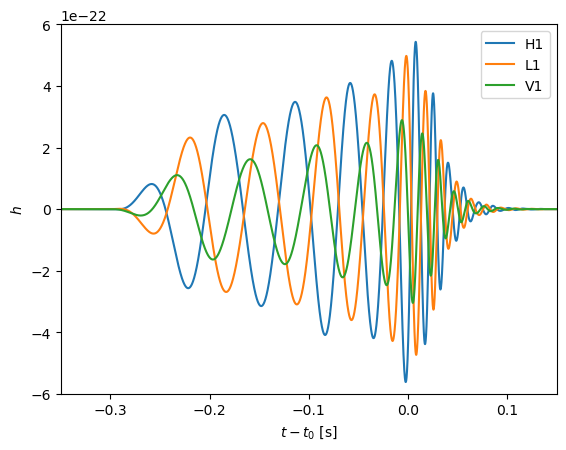

In [17]:
from scipy.signal import find_peaks

peaks_dict = {}

plt.figure()

for i, ifo in enumerate(ifos): 
    
    strain = h_ifos[ifo]
    time = raw_time_dict[ifo]
        
    plt.plot(time - tpeak_dict[ifo] , strain, color=f'C{i}', label=ifo)
    
plt.xlim(-0.35, 0.15)
    
plt.ylim(-6e-22, 6e-22)
plt.ylabel('$h$')
plt.xlabel('$t - t_0$ [s]')
plt.legend()    
        
plt.show()

Peak-finding algorithm

H1 28
L1 28
V1 28


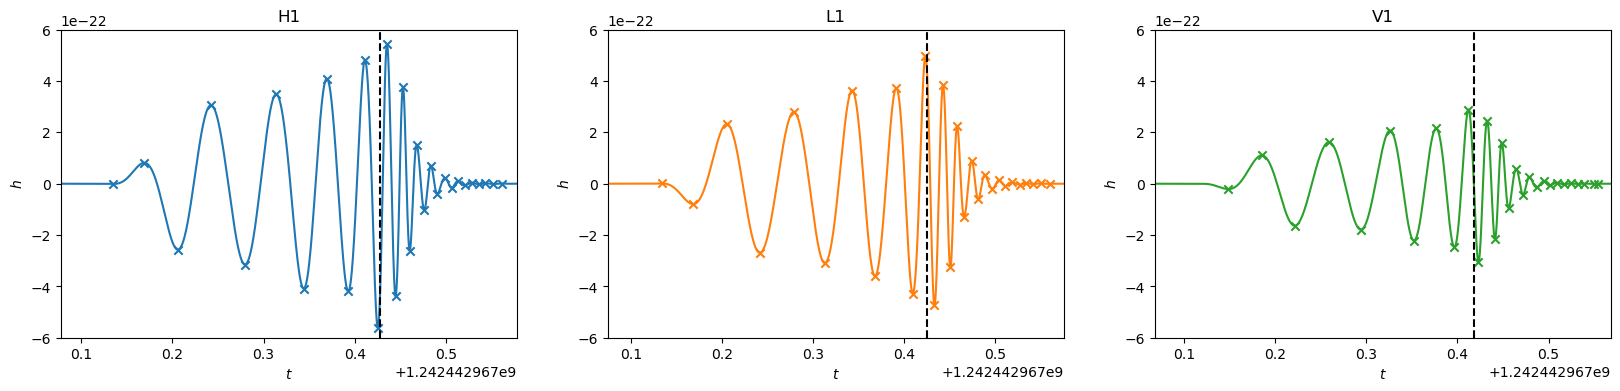

In [18]:
peaks_dict = {}

plt.figure(figsize=(20, 4))

for i, ifo in enumerate(ifos): 
    
    strain = h_ifos[ifo]
    time = raw_time_dict[ifo]
    peaks, _ = find_peaks(np.abs(strain), height=0)
    
    print(ifo, len(peaks))
    
    plt.subplot(131+i)
    
    plt.plot(time, strain, color=f'C{i}')
    plt.scatter(time[peaks], strain[peaks], c=f'C{i}', marker='x')
    
    plt.xlim(tpeak_dict[ifo] - 0.35, tpeak_dict[ifo] + 0.15)
    plt.axvline(tpeak_dict[ifo], color='k', ls='--')
    
    plt.ylim(-6e-22, 6e-22)
    plt.ylabel('$h$')
    plt.xlabel('$t$')
    plt.title(ifo)
    
    peaks_dict[ifo] = {'t':time[peaks], 'h':strain[peaks]}
    
plt.show()

H1 1242442967.3137817 [0.7580441587608995, -0.5488214795811868]
L1 1242442967.3110538 [-0.7386288711600322, 0.3652321458490877]
V1 1242442967.3044915 [0.010301417439693636, 0.49946723884571465]


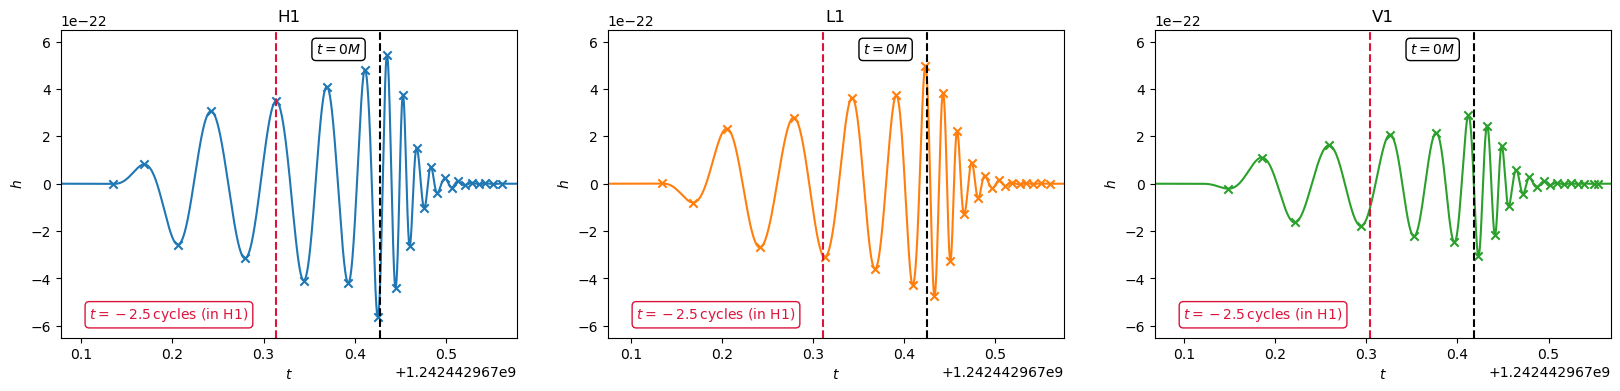

In [19]:
# See how the time shifting between the peaks works

plt.figure(figsize=(20, 4))

for i, ifo in enumerate(ifos): 
    
    strain = h_ifos[ifo]
    time = raw_time_dict[ifo]
    peaks = peaks_dict[ifo]
    
    # Choose a random peak time in H1 and transalte it between detecotrs
    tpeak_H = peaks_dict['H1']['t'][5]
    dt_H = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['H1'].location,
                                        skypos['ra'], skypos['dec'], lal.LIGOTimeGPS(tpeak_H))
    tpeaks_here, _ = get_tgps_and_ap_dicts(tpeak_H-dt_H, [ifo], skypos['ra'] , skypos['dec'], skypos['psi'])
        
    plt.subplot(131+i)
    
    plt.plot(time, strain, color=f'C{i}')
    plt.scatter(peaks['t'], peaks['h'], c=f'C{i}', marker='x')
    
    plt.xlim(tpeak_dict[ifo] - 0.35, tpeak_dict[ifo] + 0.15)
    
    # Over all peak
    plt.axvline(tpeak_dict[ifo], color='k', ls='--')
    plt.text(tpeak_dict[ifo]-0.07, 5.5e-22, '$t=0M$', color='k',  bbox=dict(facecolor=(1, 1, 1, 0.5), edgecolor='k', boxstyle='round'))
    
    # Our random peak from the H1 data
    plt.axvline(tpeaks_here[ifo], color='crimson', ls='--')
    plt.text(tpeaks_here[ifo]-0.205, -5.7e-22, '$t=-2.5\,$cycles (in H1)', color='crimson', bbox=dict(facecolor=(1, 1, 1, 0.5), edgecolor='crimson', boxstyle='round'))
    
    plt.ylim(-6.5e-22, 6.5e-22)
    plt.ylabel('$h$')
    plt.xlabel('$t$')
    plt.title(ifo)
    
plt.show()

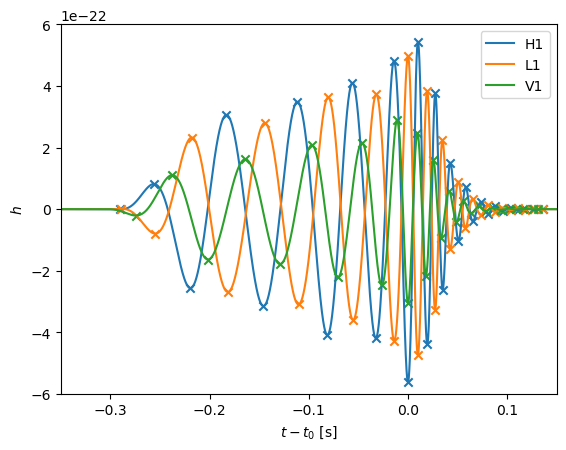

In [20]:
from scipy.signal import find_peaks

plt.figure()

for i, ifo in enumerate(ifos): 
    
    strain = h_ifos[ifo]
    time = raw_time_dict[ifo]
    peaks = peaks_dict[ifo]
    
    t_peak_max = peaks['t'][np.argmax(np.abs(peaks['h']))]
        
    plt.plot(time - t_peak_max , strain, color=f'C{i}', label=ifo)
    
    plt.scatter(peaks['t'] - t_peak_max, peaks['h'], c=f'C{i}', marker='x')
    
plt.xlim(-0.35, 0.15)
    
plt.ylim(-6e-22, 6e-22)
plt.ylabel('$h$')
plt.xlabel('$t - t_0$ [s]')
plt.legend()    
        
plt.show()

Try using the function defined in io.py

In [44]:
import scipy.signal as sig

def get_Tcut_from_Ncycles(Ncycles, **kwargs): 
    
    # Unpack inputs
    p = kwargs.pop('parameters')
    raw_time_dict = kwargs.pop('raw_time_dict')
    tpeak_dict = kwargs.pop('tpeak_dict')
    ap_dict = kwargs.pop('ap_dict')
    skypos = kwargs.pop('skypos')
    approx = kwargs.pop('approx', 'NRSur7dq4')
    f_low = kwargs.pop('f_low', 11)
    f_ref = kwargs.pop('f_ref', 11)
    
    # Get dt 
    times = raw_time_dict['H1']
    dt = times[1] - times[0]
    
    # Change spin convention
    iota, s1x, s1y, s1z, s2x, s2y, s2z = transform_spins(p['theta_jn'], p['phi_jl'], p['tilt_1'], p['tilt_2'],
                                          p['phi_12'], p['a_1'], p['a_2'], p['mass_1'], p['mass_2'],
                                          f_ref, p['phase'])


    # Get strain
    hp, hc = rwf.generate_lal_hphc(approx, 
                                   p['mass_1'], p['mass_2'],
                                   [s1x, s1y, s1z], 
                                   [s2x, s2y, s2z],
                                   dist_mpc=p['luminosity_distance'], 
                                   dt=dt,
                                   f_low=f_low, 
                                   f_ref=f_ref,
                                   inclination=iota,
                                   phi_ref=p['phase']
                                  )

    # Time align in H1
    h = rwf.generate_lal_waveform(hplus=hp, hcross=hc, times=times, triggertime=tpeak_dict['H1'])

    # Project onto H1
    Fp, Fc = ap_dict['H1']
    h_H1 = Fp*h.real - Fc*h.imag
    
    # Get indices of extrema 
    idxs, _ = sig.find_peaks(np.abs(h_H1), height=0)
    
    # Get times of extrema 
    t_cycles_H1 = times[idxs]
    
    print(len(t_cycles_H1))
        
    # Get the cycle we care about
    i0 = np.argmax(np.abs(h_H1[idxs])) # index corresponding to merger (absolute peak time)
    n_i = 2*Ncycles                    # one index = 1/2 cycle
    assert(n_i.is_integer()), '# of half cycles does not correspond to an integer value'
    icut = i0 + int(n_i)               # index corresponding to the cycle we care about
    
    
    print(i0, icut)
    
    # Get time in H1
    tcut_H1 = t_cycles_H1[icut]
    
    # Get geocenter time
    dt_H = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['H1'].location, 
                                        skypos['ra'], skypos['dec'], lal.LIGOTimeGPS(tcut_H1))
    tcut_geo = tcut_H1-dt_H
    
    return tcut_geo

28
10 5
H1 1242442967.3137817 [0.7580441587608995, -0.5488214795811868]
28
10 5
L1 1242442967.3110538 [-0.7386288711600322, 0.3652321458490877]
28
10 5
V1 1242442967.3044915 [0.010301417439693636, 0.49946723884571465]


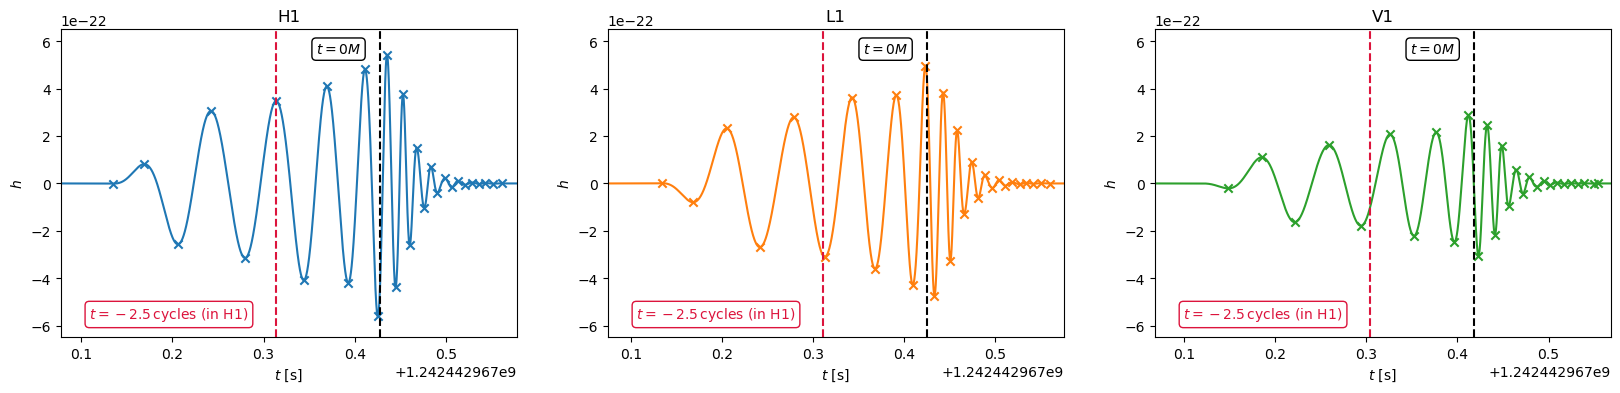

In [46]:
Ncycles = -2.5

plt.figure(figsize=(20, 4))

for i, ifo in enumerate(ifos): 
    
    strain = h_ifos[ifo]
    time = raw_time_dict[ifo]
    peaks = peaks_dict[ifo]
    
    tcut_geo = get_Tcut_from_Ncycles(Ncycles, parameters=pe_samples[imax], raw_time_dict=raw_time_dict, tpeak_dict=tpeak_dict, ap_dict=ap_dict, skypos=skypos)
    
    tcuts_here, _ = get_tgps_and_ap_dicts(tcut_geo, [ifo], skypos['ra'] , skypos['dec'], skypos['psi'])
        
    plt.subplot(131+i)
    
    plt.plot(time, strain, color=f'C{i}')
    plt.scatter(peaks['t'], peaks['h'], c=f'C{i}', marker='x')
    
    plt.xlim(tpeak_dict[ifo] - 0.35, tpeak_dict[ifo] + 0.15)
    
    # Over all peak
    plt.axvline(tpeak_dict[ifo], color='k', ls='--')
    plt.text(tpeak_dict[ifo]-0.07, 5.5e-22, '$t=0M$', color='k',  bbox=dict(facecolor=(1, 1, 1, 0.5), edgecolor='k', boxstyle='round'))
    
    # Our random cut from the H1 data
    plt.axvline(tcuts_here[ifo], color='crimson', ls='--')
    plt.text(tcuts_here[ifo]-0.205, -5.7e-22, f'$t={Ncycles}\,$cycles (in H1)', color='crimson', 
             bbox=dict(facecolor=(1, 1, 1, 0.5), edgecolor='crimson', boxstyle='round'))
    
    plt.ylim(-6.5e-22, 6.5e-22)
    plt.ylabel('$h$')
    plt.xlabel('$t$ [s]')
    plt.title(ifo)
    
plt.show()